# Descripción del proyecto

La cadena de supermercado 'Good Seed' busca tener un sistema de visión artificial que le ayude a evitar vender alcohol a personas menores de edad.

## Objetivo

Construir un modelo de visión artificial para verificar la edad de las personas, con ayuda de la información proporcionada por las cámaras colocadas en el área de pago.

## Recursos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## EDA

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',   
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw', 
    seed=12345
)

Found 7591 validated image filenames.


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


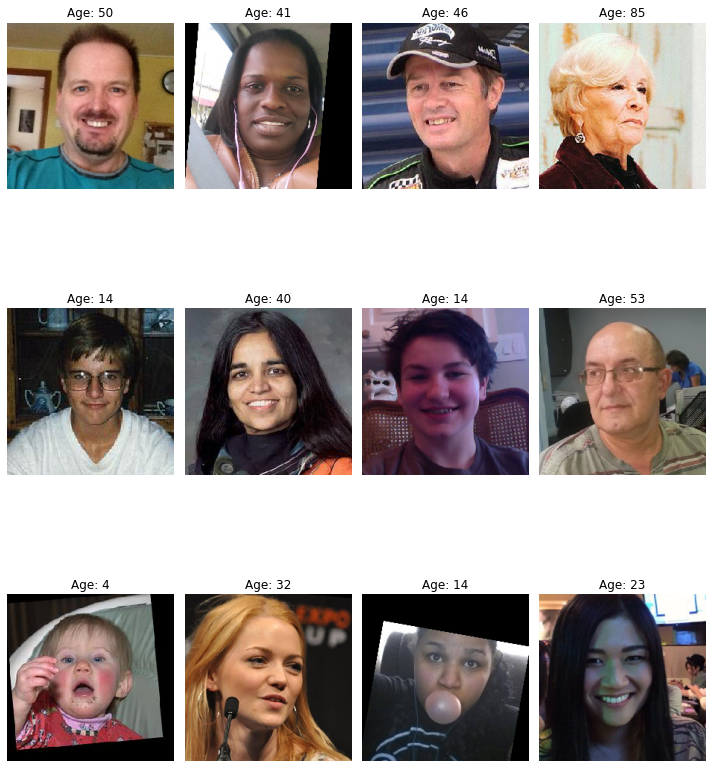

In [7]:
def show_picture(batch):
    fig = plt.figure(figsize=(10, 20))

    for i in range(12):
        fig.add_subplot(5, 4, i+1)
        plt.imshow(batch[0][i])
        plt.axis('off')
        title = f'Age: {batch[1][i]}'
        plt.title(title)

    fig.tight_layout()

show_picture(next(datagen_flow))

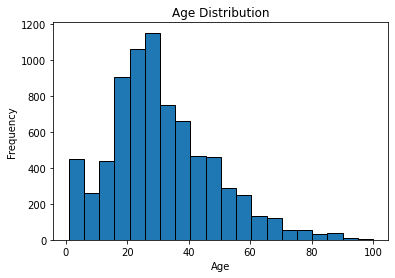

In [8]:
plt.hist(labels['real_age'], bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

### Conclusiones

El archivo `labels.csv`:

    - 2 columnas
        - file_name 'object'
        - real_age 'int64'
    - cuemta con 7591 entradas 

Se tienen 10 fotografías que no cuentan con registro en el archivo.

- Los registros van desde 1 a los 100 años
- La moda en el dataset es de 29 años
- La mitad de los registros que se tienen son de rostros que van de los 20 a los 41 años
- En el histograma se observa que la mayor parte de los registros se encuentran en el compilado de datos que van de 25 a 29 años

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=(path +'final_files/'),
    x_col='file_name',
    y_col='real_age',   
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)

    return train_gen_flow

In [ ]:
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=(path +'final_files/'),
    x_col='file_name',
    y_col='real_age',   
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(1, activation='relu'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mean_squared_error', 
        metrics=['mae'])

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Se procede a redactar un script para la plataforma GPU

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Resultado de la plataforma GPU:

Train for 178 steps, validate for 60 steps  
Epoch 1/20  
2024-04-10 00:21:33.496110: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10  
2024-04-10 00:21:34.641451: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7  
178/178 - 63s - loss: 271.3115 - mae: 11.7383 - val_loss: 719.0601 - val_mae: 21.8668  
Epoch 2/20  
178/178 - 38s - loss: 66.5213 - mae: 6.1386 - val_loss: 729.9526 - val_mae: 21.9990  
Epoch 3/20  
178/178 - 38s - loss: 31.2715 - mae: 4.3011 - val_loss: 269.6425 - val_mae: 11.9585  
Epoch 4/20  
178/178 - 38s - loss: 19.6476 - mae: 3.3939 - val_loss: 105.8659 - val_mae: 7.8516  
Epoch 5/20  
178/178 - 38s - loss: 15.7436 - mae: 2.9996 - val_loss: 87.4384 - val_mae: 7.0735  
Epoch 6/20  
178/178 - 38s - loss: 12.4514 - mae: 2.7308 - val_loss: 69.2294 - val_mae: 6.2834  
Epoch 7/20  
178/178 - 38s - loss: 10.1683 - mae: 2.4672 - val_loss: 77.7997 - val_mae: 6.6763  
Epoch 8/20  
178/178 - 38s - loss: 8.6494 - mae: 2.2343 - val_loss: 64.7391 - val_mae: 6.0350  
Epoch 9/20  
178/178 - 38s - loss: 8.6385 - mae: 2.2316 - val_loss: 68.5651 - val_mae: 6.3603  
Epoch 10/20  
178/178 - 38s - loss: 7.8697 - mae: 2.1107 - val_loss: 74.6347 - val_mae: 6.4829  
Epoch 11/20  
178/178 - 38s - loss: 6.7530 - mae: 1.9412 - val_loss: 63.1408 - val_mae: 6.0524  
Epoch 12/20  
178/178 - 38s - loss: 5.7428 - mae: 1.8025 - val_loss: 64.9688 - val_mae: 6.1105  
Epoch 13/20  
178/178 - 38s - loss: 5.0924 - mae: 1.6806 - val_loss: 64.3782 - val_mae: 5.9948  
Epoch 14/20  
178/178 - 38s - loss: 4.6321 - mae: 1.6192 - val_loss: 61.3212 - val_mae: 5.9064  
Epoch 15/20  
178/178 - 38s - loss: 4.4147 - mae: 1.5894 - val_loss: 63.5580 - val_mae: 6.0131  
Epoch 16/20  
178/178 - 38s - loss: 4.7784 - mae: 1.6525 - val_loss: 68.7139 - val_mae: 6.1933  
Epoch 17/20  
178/178 - 38s - loss: 5.0661 - mae: 1.6922 - val_loss: 65.2814 - val_mae: 6.1821  
Epoch 18/20  
178/178 - 38s - loss: 5.4177 - mae: 1.7677 - val_loss: 68.0232 - val_mae: 6.3359  
Epoch 19/20  
178/178 - 38s - loss: 5.9561 - mae: 1.8318 - val_loss: 68.5296 - val_mae: 6.2913  
Epoch 20/20   
178/178 - 38s - loss: 6.3633 - mae: 1.8900 - val_loss: 65.8422 - val_mae: 6.0713  
60/60 - 9s - loss: 65.8422 - mae: 6.0713  
Test MAE: 6.0713  

## Conclusiones

Se utilizó la arquitectura ResNet50 para desarrollar un modelo de visión artificial. Se especificó la función de activación 'relu' para transformar los valores negativos en 0. Además, se añadió una capa final con una neurona para obtener una única salida, ya que se trata de un problema de regresión.

La función de pérdida seleccionada fue 'mse' (Mean Squared Error), que mide la discrepancia entre las predicciones del modelo y las etiquetas verdaderas. La métrica utilizada fue 'mae' (Mean Absolute Error), que calcula el promedio de las diferencias absolutas entre las predicciones y las etiquetas reales.

En los resultados obtenidos, se observó que la pérdida (loss) fue bastante baja, lo que sugiere que el modelo hizo predicciones cercanas a las etiquetas verdaderas. Además, el error absoluto medio (MAE) indicó que, en promedio, el modelo se equivocó aproximadamente en 6.07 años al predecir la edad de una persona.

Para mejorar las métricas, se recomienda equilibrar más las imágenes de personas más jóvenes y prestar especial atención a aumentar las fotografías de personas cercanas a la mayoría de edad. Esto permitirá que el modelo aprenda más sobre las características de estas personas, que son aquellas a las que el centro comercial desea evitar vender alcohol.